### Análisis y Procesamiento de Señales - 2do Cuatrimestre 2025
# **Tarea Semanal 9**: *Filtrado No Lineal*
#### Mora Taranilla y Victoria Jazmín Salgado

## **Resumen**
En esta Tarea Semanal se experimentó con tres técnicas diferentes de filtrado **No Lineal**: Filtro de Mediana, Interpolación mediante Splines Cúbicos y Filtro Adaptado (*matched filter*). El objetivo fue mitigar la interferencia del movimiento de línea de base de una señal de ECG.

## **Introducción Teórica**
Las señales de ECG presentan interferencias de diversa naturaleza. Sin embargo, aquella que resulta más exigente para el diseño de los filtros digitales con los que se experimentó anteriormente (lineales) es el **Movimiento de Línea de Base**. Éste fenómento consiste en oscilaciones de muy baja frecuencia (<0.5Hz) pero de amplitud considerable, afectando apreciablemente a la señal de ECG que se desea estudiar. La dificultad radica en que al intentar remover éstas frecuencias con filtros lineales tradicionales se corre el riesgo de introducir distorsiones de fase en la señal de ECG, alterando su morfología, aspecto clave para el análisis clínico. 

El objetivo de este trabajo es analizar diversas técnicas que permiten realizar una estimación de la señal de movimiento de base $\hat b(n)$, para luego sustraerla de la señal original $s$ (ECG con interferencias). De esta forma, se obtiene una estimación de la señal filtrada $\hat{x}$, mediante:
$$\hat{x} = s - \hat{b}$$

A continuación se experimenta con tres técnicas de filtrado no lineal. Se denominan así porque no satifacen el principio de superposición, ya que la respuesta del filtro ante una suma de señales no es igual a la suma de las respuestas individuales. 

A diferencia de los filtros lineales, éstos métodos basan su operación en la estadística local o en la morfología específica de la señal.
Por lo tanto, es necesario conocer la naturaleza de ésta para poder utilizar estas técnicas de manera adecuada.

En este caso, se aprovechan propiedades propias del ECG, como por ejemplo la duración típica de los complejos para el uso de filtros de mediana, o la separación temporal entre puntos isoeléctricos para el método de splines cúbicos. Esto permite que las técnicas trabajen correctamente y logren estimar la línea de base sin distorsionar la información relevante. 

Se detalla el concepto detrás de cada técnica a continuación, junto con un análisis de su performance para la estimación de la señal filtrada. 

## **Desarrollo y Análisis**

Para llevar a cabo el filtrado, se utilizaron las librerías de scipy, numpy y matplotlib. En todos los casos, fue utilizada la misma señal de ECG resuperada del archivo *ECG_TP4.mat*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 
import scipy.io as sio
import scipy.interpolate as interp

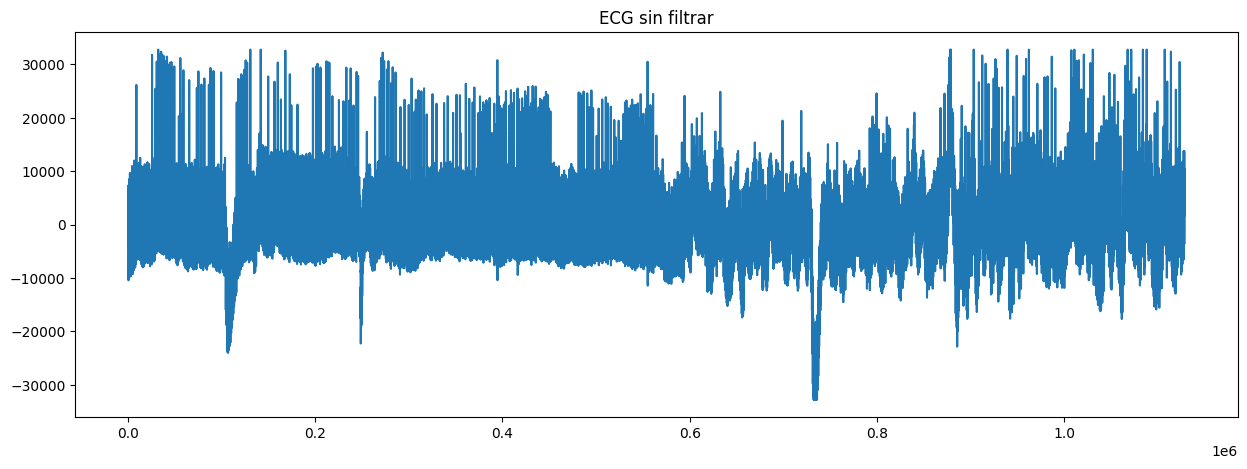

In [2]:
#Lectura de ECG con ruido
fs_ecg = 1000 # Hz

sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].squeeze()
N = len(ecg_one_lead)

plt.figure(figsize=(15,5))
plt.plot(ecg_one_lead)
plt.title('ECG sin filtrar')
plt.show()

1. Filtrado por mediana

Este método consta en la utilización del siguiente estimador:

$$
\hat b(n) = \underset{600}{med}(\underset{200}{med}(s))
$$

Siendo $s$ la señal con ruido. El operador $\underset{t}{med} (s)$, aplicado mediante la función de scipy.signal *medfilt*, retorna un vector de la misma longitud que la señal de entrada, para la cual, cada espacio del mismo toma el valor de la mediana de $t$ milisegundos (en este caso corresponde a la misma cantidad de muestras, ya que la frecuencia de muestreo es de 1000 Hz). Primero, se realiza para 200 muestras y luego para 600 muestras. El orden es de suma importancia para el funcionamiento correcto del filtro. 

En primer lugar se aplica para 200 ms, para eliminar asi los complejos QRS. Sucede de esta forma, ya que los mismos tienen un soporte aproximado de 150 ms, y presentan valores extremos en la señal. Al aplicar la mediana, estos valores atípicos se reducen en magnitud. Luego se aplica para 600 ms, para filtrar las ondas P y T, las cuales tienen soportes más amplios, entre 100 ms y 300 ms. Al eliminarse todas las ondas características del ECG, se obtiene una buena estimación del movimiento de la linea de base que presenta la señal.

A continuación se observan gráficamente los resultados de cada paso y el resultado final de la señal filtrada.

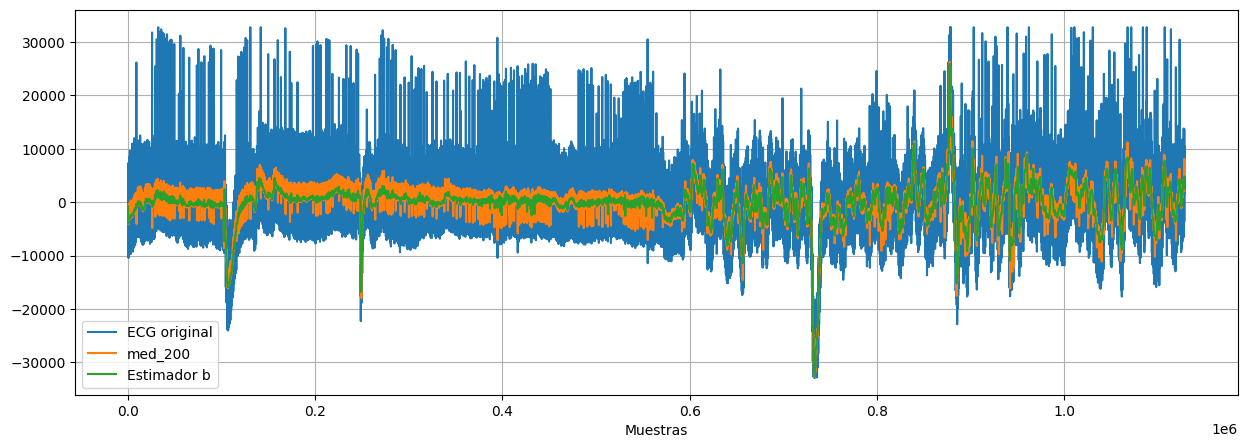

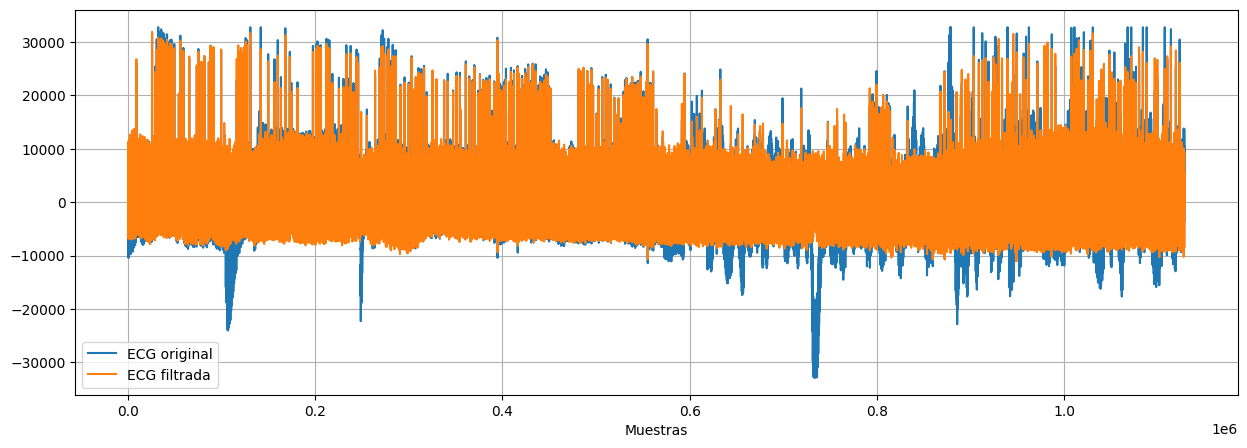

In [3]:
x = ecg_one_lead

filtrada = signal.medfilt(x, 201)
filtrada_600 = signal.medfilt(filtrada, 601)

plt.figure(figsize=(15,5))
plt.plot(x, label='ECG original')
plt.plot(filtrada, label='med_200')
plt.plot(filtrada_600, label='Estimador b')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.show()

Para visualizar mejor, se realiza un gráfico con menor cantidad de muestras.

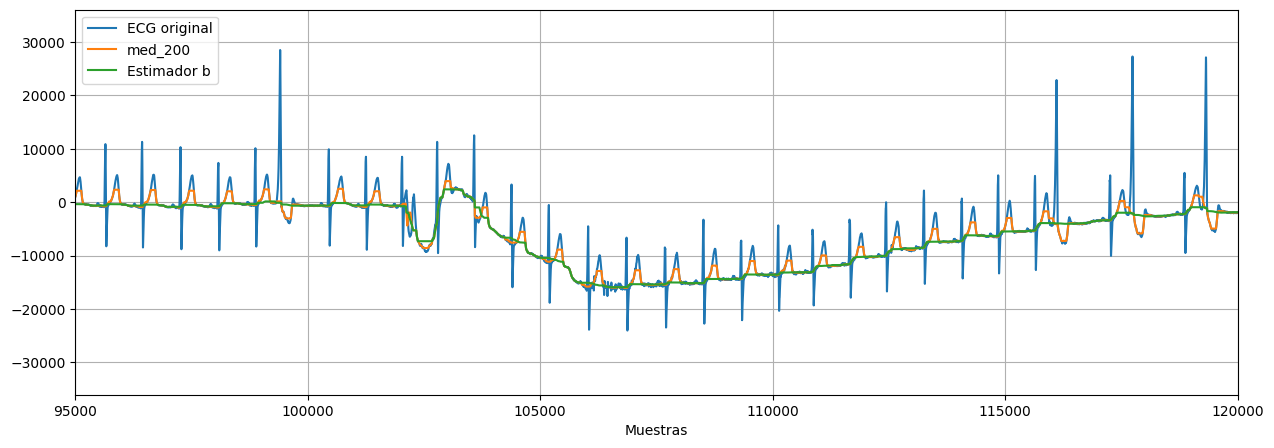

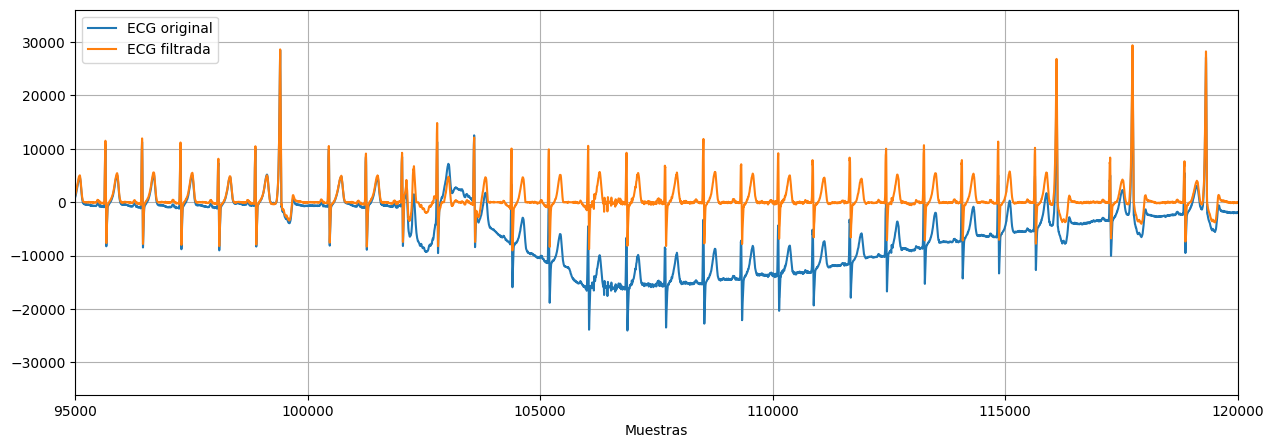

In [4]:
plt.figure(figsize=(15,5))
plt.plot(x, label='ECG original')
plt.plot(filtrada, label='med_200')
plt.plot(filtrada_600, label='Estimador b')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(95000,120000)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(95000,120000)
plt.show()

A partir de estos nuevos gráficos, se puede observar que el estimador $\hat b$ es una gran aproximación del movimiento de linea de base. Esto se refleja directamente en el gráfico que muestra ambas señales de ECG, ya que al realizar la resta entre $s$ y $\hat b$ se observa que la linea de base es llevada a cero. De esta forma se demuestra que es un buen método de filtrado no lineal. 

A continuación se observa el rendimiento para secciones con poco ruido (izquierda) y mucho ruido (derecha).

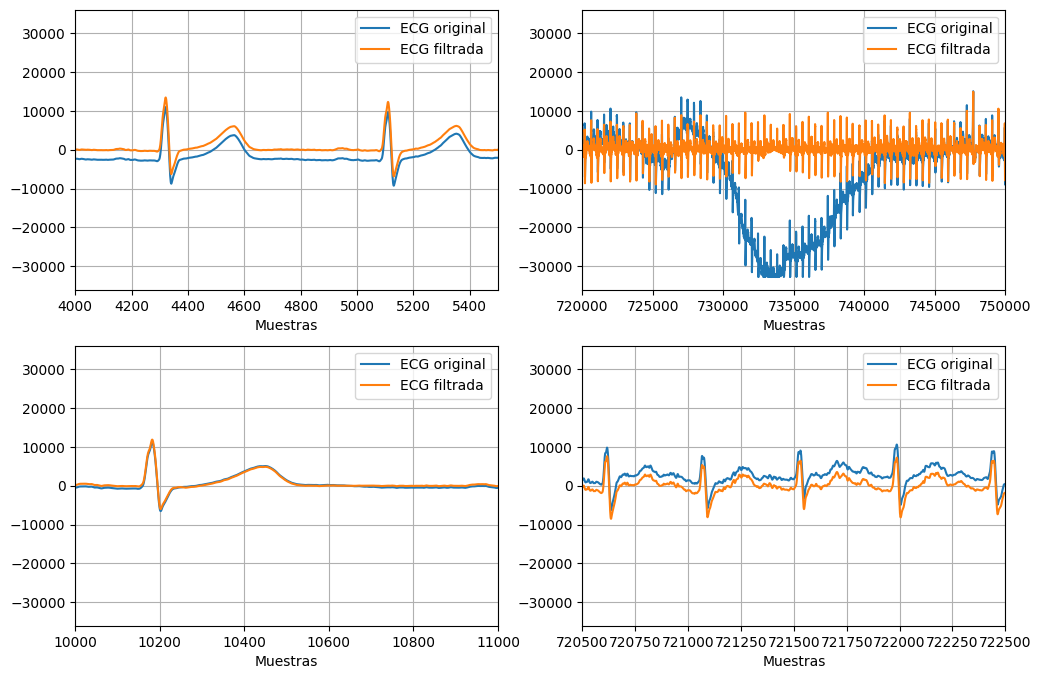

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(4000,5500)

plt.subplot(2,2,2)
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(720000,750000)

plt.subplot(2,2,3)
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(10000,11000)

plt.subplot(2,2,4)
plt.plot(x, label='ECG original')
plt.plot(x-filtrada_600, label='ECG filtrada')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(720500,722500)

plt.show()

Para las secciones sin ruido, se observa que la señal tiene oscilaciones no esperadas para un ECG, pero se debe a ruido de frecuencias más elevadas a las que modifican la linea de base. Es por ello que se puede concluir que el filtrado por mediana funciona de forma correcta para la eliminación de frecuencias bajas. Hacia al final de la señal, la misma cuenta con mucha interferencia de alta y baja frecuencia. Ya como fue mencionado anteriormente, el filtrado utilizado no actua sobre altas frecuencias, por lo cual no se observa en las secciones con más ruido la forma esperada para un ECG. De igual forma, la linea de base es llevada a cero.

Se puede decir en grandes rasgos, que es una herramienta útil para eliminar el ruido de frecuencias bajas. Si reparamos sobre las ventajas, tiene implementación sencilla y es robusto frente valores extremos. Aunque es de facil implementación, es de suma importancia conocer la morfología de la señal para definir correctamente la cantidad de muestras que utilizan las medianas. Una gran desventaja que presenta el método es el alto costo computacional, ya que realiza $2N$ medianas. En este caso, se podría llevar a cabo un diezmado de la señal, ya que la misma esta sobremuestreada (a 1000Hz) para su ancho de banda, el cual no supera los 50Hz. Si se realiza un diezmado del mismo, implica una menor cantidad de medianas, y por lo tanto un menor costo computacional.

2. Interpolación por Splines Cúbicos

Para este método de estimación del movimiento de linea de base se utilizaron splines cubicos. Para llevar a cabo la interpolación se tomaron puntos de las secciones isoeléctricas de la señal, entre la onda P y el complejo QRS. En ese intervalo de tiempo, no hay actividad eléctrica y la señal debería ser constante e igual a cero. Al interpolar con estos puntos, obtenemos una buena aproximación del movimiento de linea de base.

Los splines cúbicos tienen la particularidad que conecta cada punto a interpolar con polinomios de tercer grado, asegurando que se conecten con suavidad en cada punto. De esta forma soporta hasta la tercera derivada.

Para la implementación se tomaron los datos provistos por el archivo de *ECG_TP4.mat*, *qrs_detections*. Este archivo contiene puntos del complejo QRS, el cual fue trasladado a un vector, donde explicita en cual muestra se encuenta el pico. Al restarle 110 muestras, se encontraron puntos que deben pertenecen a las secciones isoelectricas. 

A continuación, se visualizan los puntos del complejo QRS y la aproximación de los puntos donde la señal debería ser isoeléctrica.

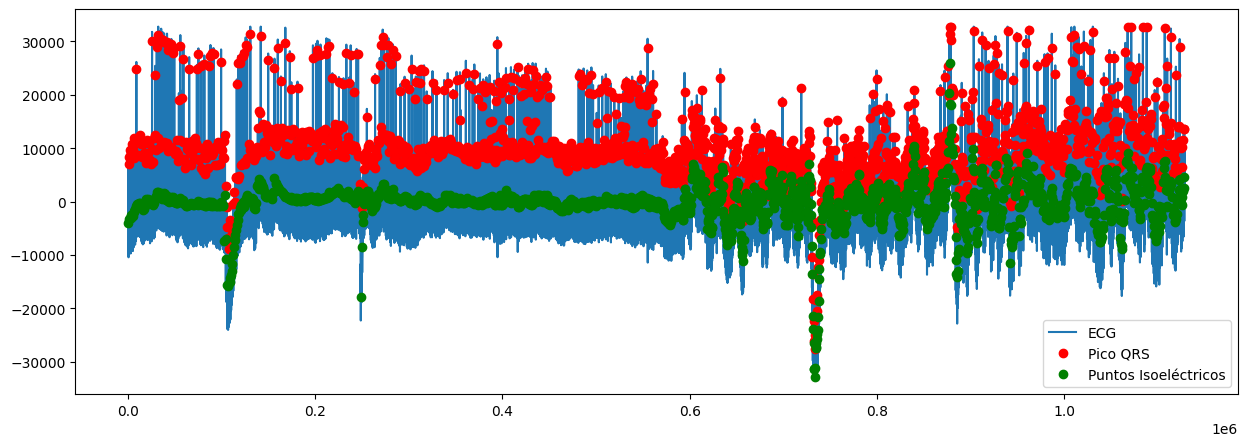

In [6]:
qrs_detections = mat_struct['qrs_detections'].squeeze()
M = len(qrs_detections)

puntos_spline = np.array(qrs_detections - 110, dtype=int).flatten()

plt.figure(figsize=(15,5))
plt.plot(ecg_one_lead, label='ECG')
plt.plot(qrs_detections, ecg_one_lead[qrs_detections.astype(int)], 'ro', label='Pico QRS')
plt.plot(puntos_spline, ecg_one_lead[puntos_spline], 'go', label='Puntos Isoeléctricos')
plt.legend()
plt.show()

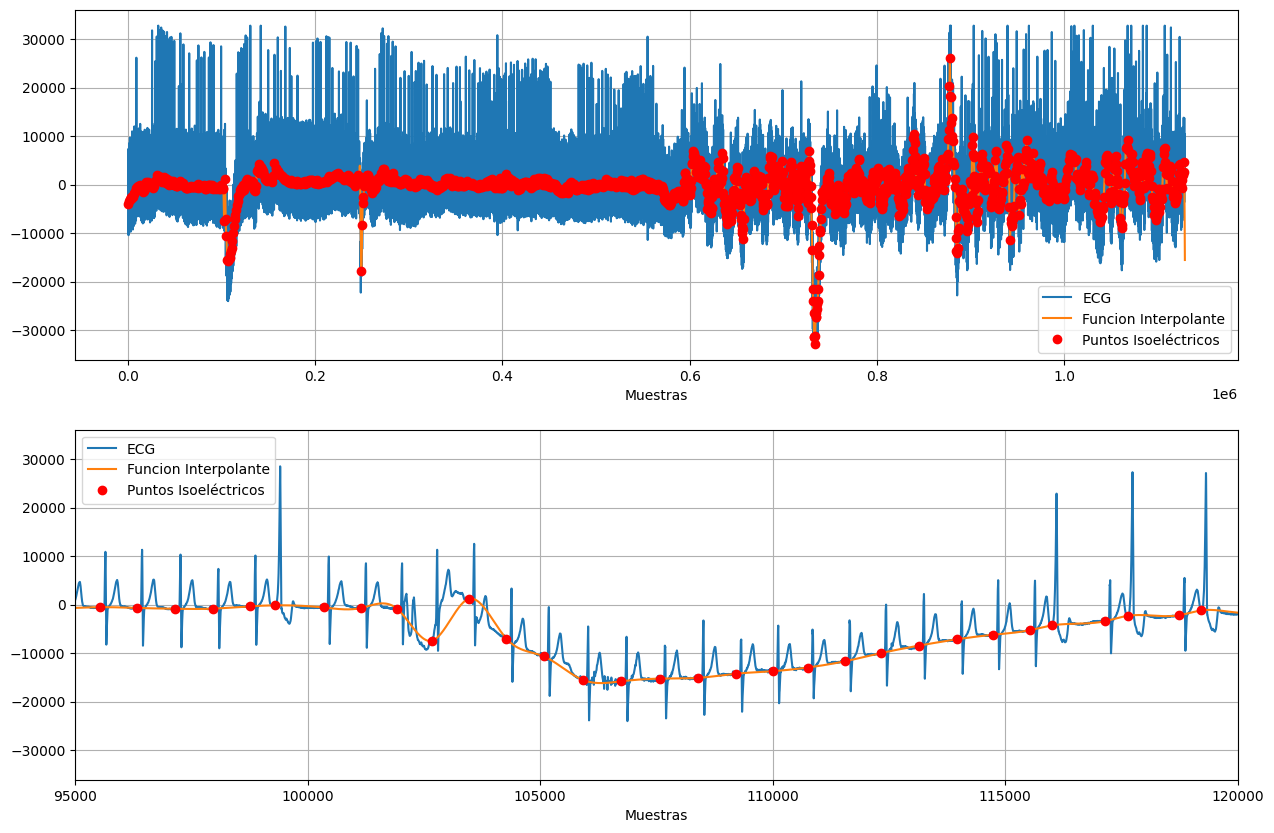

In [7]:
interpolacion = interp.CubicSpline(puntos_spline, ecg_one_lead[puntos_spline])

ejex = np.arange(len(ecg_one_lead))
interpolado = interpolacion(ejex)

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ecg_one_lead, label='ECG')
plt.plot(interpolado, label = 'Funcion Interpolante')
plt.plot(puntos_spline, ecg_one_lead[puntos_spline], 'ro', label='Puntos Isoeléctricos')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ecg_one_lead, label='ECG')
plt.plot(interpolado, label = 'Funcion Interpolante')
plt.plot(puntos_spline, ecg_one_lead[puntos_spline], 'ro', label='Puntos Isoeléctricos')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(95000,120000)
plt.show()

A simple vista se obsereva que se aproxima bien el movimiento del piso de ruido. Para finalizar, lo que resta es hacer la sustracción. Se grafican ambas señales, nuevamente para las secciones anteriormente mencionadas.

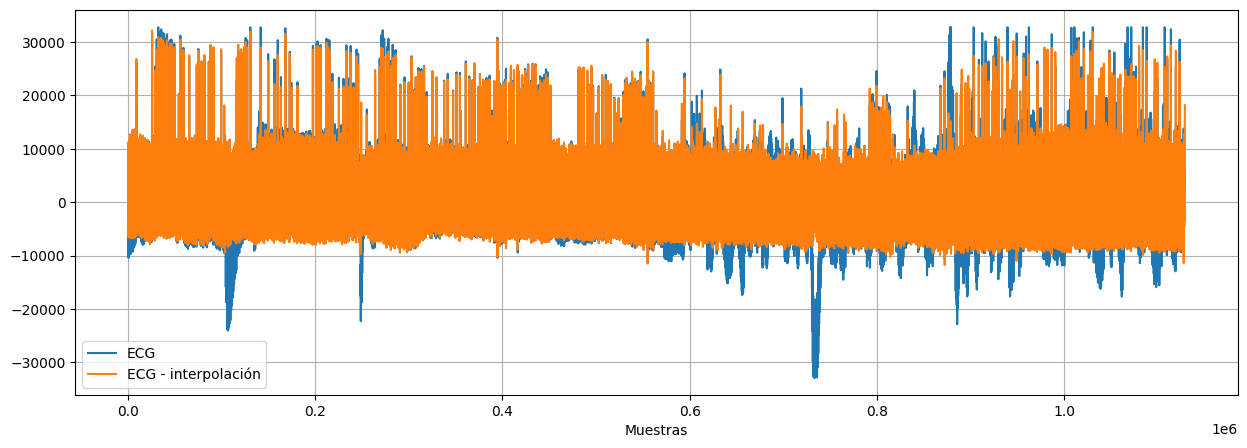

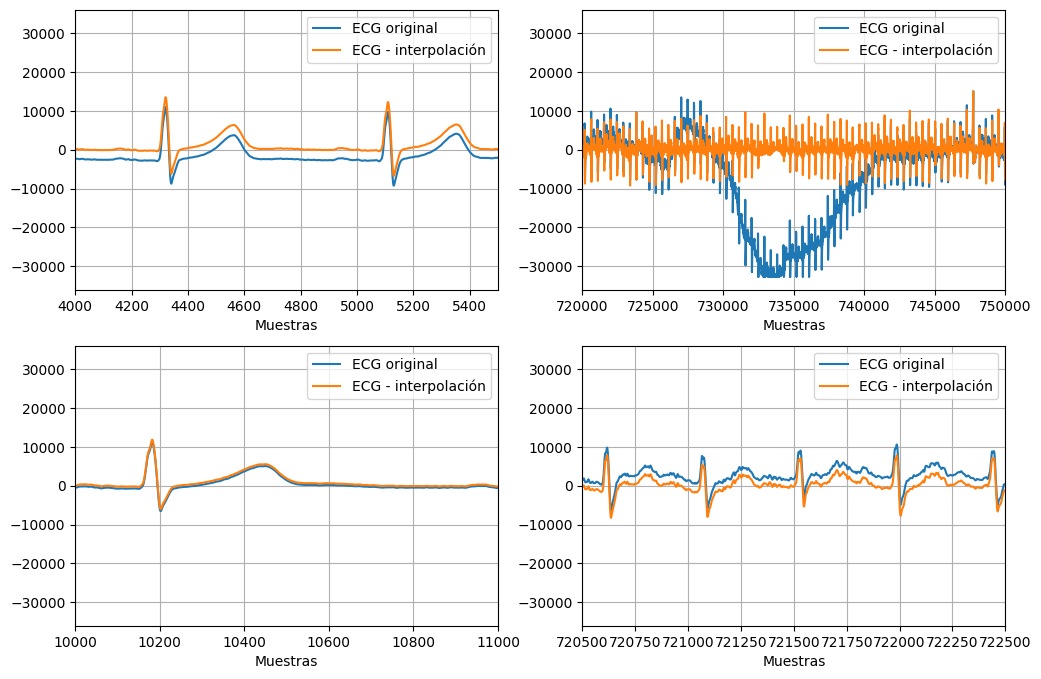

In [8]:
plt.figure(figsize=(15,5))
plt.plot(ecg_one_lead, label='ECG')
plt.plot(ecg_one_lead-interpolado, label='ECG - interpolación')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(x, label='ECG original')
plt.plot(ecg_one_lead-interpolado, label='ECG - interpolación')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(4000,5500)

plt.subplot(2,2,2)
plt.plot(x, label='ECG original')
plt.plot(ecg_one_lead-interpolado, label='ECG - interpolación')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(720000,750000)

plt.subplot(2,2,3)
plt.plot(x, label='ECG original')
plt.plot(ecg_one_lead-interpolado, label='ECG - interpolación')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(10000,11000)

plt.subplot(2,2,4)
plt.plot(x, label='ECG original')
plt.plot(ecg_one_lead-interpolado, label='ECG - interpolación')
plt.xlabel('Muestras')
plt.legend()
plt.grid(True)
plt.xlim(720500,722500)
plt.show()

Se observa que el filtro no incorporó oscilaciones que antes no estaban. Tiene un buen rendimiento, ya que mitiga las interferencias de baja frecuencia, llevando la linea de base a cero. Nuevamente, el filtro no elimina las interferencias de alta frecuencia, por lo que se observan oscilaciones no caracteristicas de una señal ECG. En este caso también fue necesario el conocimiento acerca de la morfología para determinar que puntos se debían interpolar. 

Se puede decir que su implementación no es compleja, pero si es más laboriosa que la del filtro de mediana. En este caso ya habían sido proporcionadas las ubicaciónes de los picos del complejo QRS, pero en caso de no serlo, lleva más pasos. La ubicación de los picos del complejo QRS también pueden presentar un conflicto cuando existen latidos irregulares, lo que puede interferir en la ubicación de las secciones isoeléctricas y como consecuencia en la interpolación. De igual forma, es una gran herramienta para aproximar el movimiento de linea de base y eliminar las bajas frecuencias del ECG. 

3. Filtro Adaptado (*Matched Filter*)

Al implementar un filtro adaptado, la salida obtenida equivale a la correlación cruzada entre la señal que se desea analizar (el ECG) y un *template* o patrón conocido. El objetivo es, entonces, detectar la presencia de este *template* en la señal original, buscando los máximos locales en la salida del filtro, que indican los instantes de mayor similitud morfológica. 

En este trabajo, este tipo de filtrado se utiliza para la detección de latidos, aprovechando la similitud morfológica entre un patrón de referencia y el complejo QRS, que es el componente más distintivo de cada latido. Se utilizó el patrón provisto en la variable *qrs_pattern1*, a la cual se le restó el valor medio para garantizar energía neta nula. De esta manera el filtro reaccionará a la forma de la onda y no al nivel de continua. 

Para el filtrado se empleó la función lfilter, que implementa una convolución causal con la señal original. Idealmente, una correlación cruzada requeriría invertir temporalmente el patrón; sin embargo, dado que el template utilizado es prácticamente simétrico, la diferencia entre convolución y correlación real es mínima y no afecta la detección.

Finalmente, se tomó el valor absoluto de la salida y se normalizó respecto a su desvío estándar. Para la visualización y detección, se corrigió el retardo de grupo propio del filtro (introducido por su naturaleza causal) descartando las primeras 57 muestras. De esta manera, los picos de salida de correlación quedarán alineados temporalmente con los complejos QRS de la señal original.

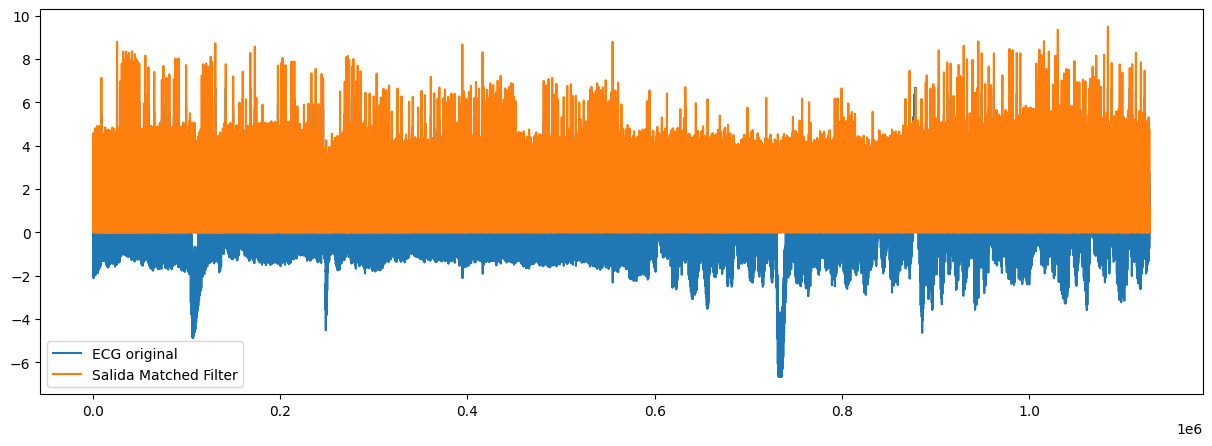

In [9]:
patron = mat_struct['qrs_pattern1'].flatten()
patron_2 = patron - np.mean(patron) #para tener area neta nula, util para filtrar

ecg_detection = signal.lfilter(b=patron_2, a=1, x=ecg_one_lead)

ecg_detection_abs = np.abs(ecg_detection)
ecg_detection_abs = ecg_detection_abs/np.std(ecg_detection_abs)

ecg_one_lead_dev = ecg_one_lead/np.std(ecg_one_lead)

mis_qrs, _ = signal.find_peaks(ecg_detection_abs, height=1, distance=300) #300 parametro electrofisiologico

plt.figure(figsize=(15,5))
plt.plot(ecg_one_lead_dev, label = 'ECG original')
plt.plot(ecg_detection_abs[57:], label = 'Salida Matched Filter')
plt.legend()

plt.show()

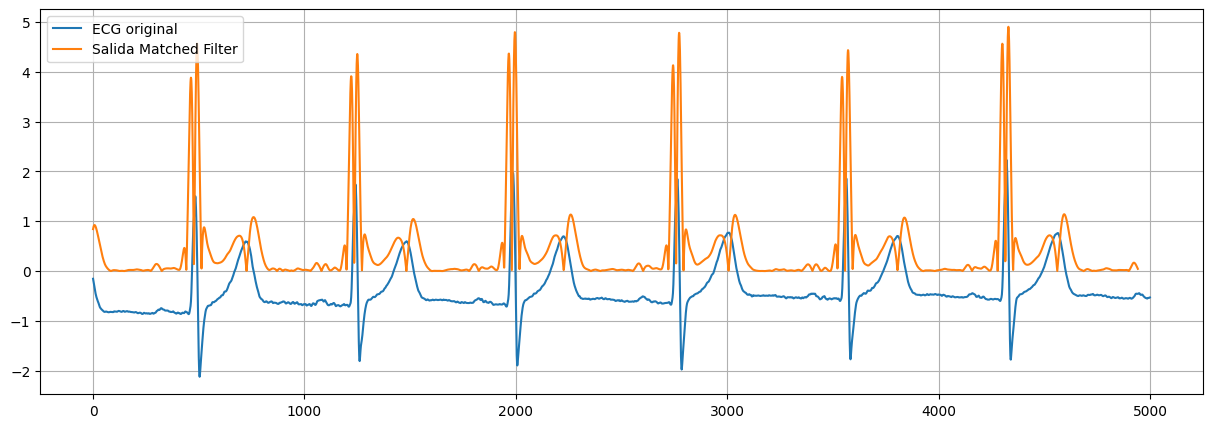

In [10]:
plt.figure(figsize=(15,5))
plt.plot(ecg_one_lead_dev[:5000], label = 'ECG original')
plt.plot(ecg_detection_abs[57:5000], label = 'Salida Matched Filter')
plt.legend()
plt.grid(True)

Se verificó visualmente la alineación temporal entre los máximos de la salida del filtro (luego de compensar el retardo) y los complejos QRS de la señal original. Esta coincidencia es un primer indicador cualitativo del correcto funcionamiento del filtro adaptado. 

Posteriormente se procede al cálculo de la matriz de confusión, con el fin de evaluar cuantitativamente el desempeño del detector de latidos. Para ello se utilizaron las marcas de referencia (*gold standard*) disponibles también en *ECG_mat.tp4*, las cuales fueron comparadas con las detecciones obtenidas por el algoritmo *find_peaks* de *scipy.signal*, implementado anteriormente sobre la señal de salida del filtro (una vez tomado valor absoluto y normalizada por desvío estándar). 

Debido a que la coincidencia temporal exacta de los picos de la señal de ECG y de la salida del filtro es improbable, se determina una ventana de tolerancia temporal de 150ms. Luego se establece un criterio de evaluación que devolverá:

- TP (*True Positive*) $\rightarrow$ si una detección cae dentro de la ventana de tolerancia respecto de una marca de referencia (del gold standard)
- FP (*False Positive*) $\rightarrow$ una detección del algoritmo que no tiene correspondencia con una marca real
- FN (*False Negative*) $\rightarrow$ Un latido real que el algoritmo no detectó.

A partir de los valores obtenidos para estos parámetros, se calcularon métricas que permiten evaluar el rendimiento.

In [11]:
qrs_det = mat_struct['qrs_detections'].flatten()

In [12]:
def matriz_confusion_qrs(mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    """
    Calcula matriz de confusión para detecciones QRS usando solo NumPy y SciPy
    
    Parámetros:
    - mis_qrs: array con tiempos de tus detecciones (muestras)
    - qrs_det: array con tiempos de referencia (muestras)  
    - tolerancia_ms: tolerancia en milisegundos (default 150ms)
    - fs: frecuencia de muestreo (default 360 Hz)
    """
    
    # Convertir a arrays numpy
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)
    
    # Convertir tolerancia a muestras
    tolerancia_muestras = tolerancia_ms * fs / 1000
    
    # Inicializar contadores
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    
    # Arrays para marcar detecciones ya emparejadas
    mis_qrs_emparejados = np.zeros(len(mis_qrs), dtype=bool)
    qrs_det_emparejados = np.zeros(len(qrs_det), dtype=bool)
    
    # Encontrar True Positives (detecciones que coinciden dentro de la tolerancia)
    for i, det in enumerate(mis_qrs):
        diferencias = np.abs(qrs_det - det)
        min_diff_idx = np.argmin(diferencias)
        min_diff = diferencias[min_diff_idx]
        
        if min_diff <= tolerancia_muestras and not qrs_det_emparejados[min_diff_idx]:
            TP += 1
            mis_qrs_emparejados[i] = True
            qrs_det_emparejados[min_diff_idx] = True
    
    # False Positives (tus detecciones no emparejadas)
    FP = np.sum(~mis_qrs_emparejados)
    
    # False Negatives (detecciones de referencia no emparejadas)
    FN = np.sum(~qrs_det_emparejados)
    
    # Construir matriz de confusión
    matriz = np.array([
        [TP, FP],
        [FN, 0]  # TN generalmente no aplica en detección de eventos
    ])
    
    return matriz, TP, FP, FN

# Ejemplo de uso

matriz, tp, fp, fn = matriz_confusion_qrs(mis_qrs, qrs_det)

print("Matriz de Confusión:")
print(f"           Predicho")
print(f"           Sí    No")
print(f"Real Sí:  [{tp:2d}   {fn:2d}]")
print(f"Real No:  [{fp:2d}    - ]")
print(f"\nTP: {tp}, FP: {fp}, FN: {fn}")

# Calcular métricas de performance
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nMétricas:")
print(f"Precisión: {precision:.3f}")
print(f"Sensibilidad: {recall:.3f}")
print(f"F1-score: {f1_score:.3f}")


Matriz de Confusión:
           Predicho
           Sí    No
Real Sí:  [1902    1]
Real No:  [ 3    - ]

TP: 1902, FP: 3, FN: 1

Métricas:
Precisión: 0.998
Sensibilidad: 0.999
F1-score: 0.999


Los valores obtenidos para la matriz de confusión confirman el buen desempeño del filtro adaptado propuesto para la detección de latidos a partir del segmento QRS.

Se obtuvieron valores para precisión, sensibilidad y f1-score muy cercanos a 1, siendo 1 el ideal.

La sensibilidad de 0.999 indica que el algoritmo fue capaz de identificar correctamente 1902 latidos, perdiendo únicamente un evento (1 Falso Negativo) en todo el registro analizado. 
La presición del 0.998 indica una alta inmuidad al ruido y artefactos, ya que se registraron sólo 3 falsos positivos. Esto quiere decir que se logró discriminar entre la morfología del segmento QRS y otras ondas o interferencias presentes en la señal, gracias al patrón utilizado. 
El valor de F1-score de 0.999 demuestra que el filtro adaptado fue una herramienta robusta para la detección de latidos en una señal de ECG. 

## **Conclusión**

A partir del trabajo realizado se puede concluir que estos métodos son, en rasgos generales, de simple implementación y efectivos. No implican un diseño de plantilla, como en los métodos lineales (filtros FIR e IIR). Una gran diferencia frente a los métodos lineales, es que los mismos reducen la interferencia de alta y baja frecuencia (determinados por la banda de paso y de rechazo), mientras que los estudiados en este trabajo únicamente mitigan las bajas frecuencias.

En cuanto al método de mediana, el mismo implica un alto costo computacional. Este conflicto puede reducirse al diezmar la señal o realizar el muestreo original a una frecuencia más baja. Su implementación es la más sencilla de todos los métodos vistos y cumple con lo esperado. Por otro lado, el método de splines cúbicos puede presentar conflictos en la detección de los puntos isoeléctricos, lo que puede interferir en la estimación del movimiento de linea de base. De igual manera, ambos presentan buenos resultados para la eliminación del ruido de baja frecuencia.

Por último, 

## **Autoevaluación**
**Indicar una opción**:
*Resolví la tarea sin dudas*

**Responder**:

*¿Qué aprendiste al hacer esta tarea? ¿Qué te quedó claro? ¿Qué te sigue costando?*
Aprendimos sobre el filtrado de señales a partir de métodos no lineales. Logramos comprender el razonamiento detrás de los estimadores de movimiento de linea de base. Además, logramos distinguir las ventajas y desventajas que los distintos tipos de filtrado presentan.

**Indicar si se utilizó IA**:
Se utilizó la IA para terminar de comprender conceptos teóricos.